# 11_1 In class example, Classification with questions
We will load the breast cancer dataset and figure out what is the most important predictor(s) for breast cancer. And then see what happens to the prognosis when these predictors are permuted.

<mark>Note:  Any data gleaned from this sort of thing is only as good as your model.  So if your model is very bad at making predictions then it's notions about what are the most important predictors are also very bad!

<!--See <a href="https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py">this</a> page for a different take on removing correlated columns-->

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
#want to filter the seaborn warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)


# Load Data

In [223]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
# X, y = data.data, data.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [224]:
#want a description of the dataset?
# for line in data.DESCR.split("\n"):
#     print(line)

In [225]:
# data['feature_names']

In [226]:
#want to see it all in a dataframe?
df = pd.DataFrame(data= np.c_[data['data']],
                     columns= data['feature_names'])
y=pd.Series(data['target'])
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [227]:
#is it balanced?
print(f' %{y.sum()/y.shape[0]*100} of dataset is non-cancerous')

 %62.741652021089635 of dataset is non-cancerous


## Any correlations?  If so dump em
Correlations interfere with calculating importance.  For instance, if you have 2 highly correlated columns; A and B.  If you scramble A then B still has As information.  This will result in a lower importance value for both features, where they might actually be important.

In [228]:
# import utils as ut
# ut.get_correlated_columns(df,correlation_threshold=0.90)

In [239]:
# fig, ax = plt.subplots(figsize=(15, 15))
corr = df.corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

#BTW how do you choose a threshold here? If you vary this from .98 to .65 you will see a decrease and then increase in model accuracy.
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f'Dropping {to_drop}')
df=df.drop(columns=to_drop)
to_drop=[]

Dropping ['mean concave points', 'worst texture', 'worst compactness', 'worst concavity', 'worst concave points']


# Get train test split

In [240]:
#get train test split
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

# Any additional columns to Drop?

Use this to drop any useless features that permutation importance finds

In [251]:
X_train.drop(columns=to_drop,inplace=True)
X_test.drop(columns=to_drop,inplace=True)

# Train a model

In [252]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.98


# Check metrics

In [243]:
from sklearn.metrics import classification_report
def show_metrics(clf,X,Y):
    res = clf.predict(X)
    prec_rec = classification_report(Y, res)
    print (prec_rec)
    
show_metrics(clf,X_test,y_test)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.98      0.99      0.98        89

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



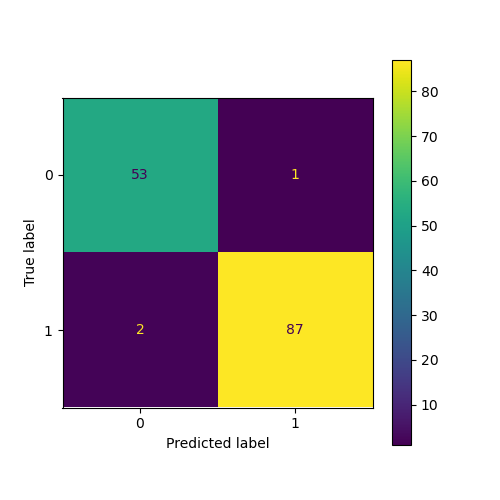

In [261]:
# Thats a little lean in terms of content
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, clf.predict(X_test), labels=[0,1])
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1]).plot(ax=ax)

# Permutation importance

In [245]:
from sklearn.inspection import permutation_importance

In [255]:
%%time
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42,  scoring='accuracy')
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

CPU times: user 1.2 s, sys: 3.93 ms, total: 1.2 s
Wall time: 1.2 s


In [256]:
#do we want to drop all the columns that permutation importance say are unimportant?
to_drop=[forest_importances.index[i] for i,val in enumerate(forest_importances) if val <=0]
to_drop

[]

In [257]:
#it looks like the bottom 3 do not matter at all
to_drop=list(forest_importances[:3].index)

In [121]:
forest_importances.index

Index(['mean compactness', 'worst symmetry', 'mean fractal dimension',
       'worst fractal dimension', 'smoothness error', 'mean symmetry',
       'concave points error', 'compactness error', 'symmetry error',
       'fractal dimension error', 'worst smoothness', 'radius error',
       'mean texture', 'mean concavity', 'mean radius'],
      dtype='object')

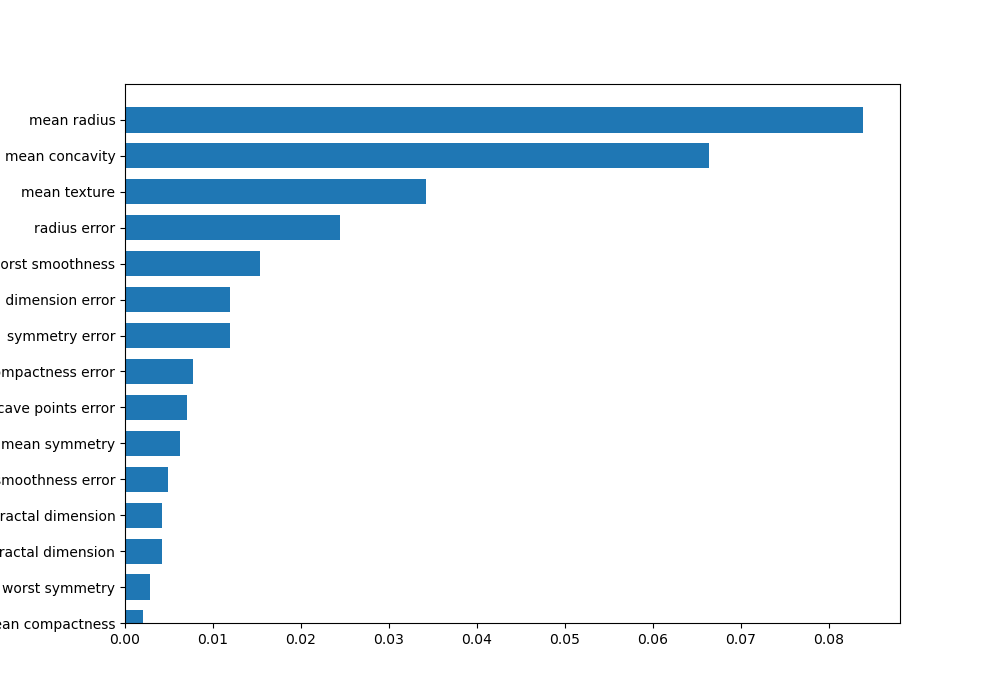

In [258]:
#plot em
forest_importances = forest_importances.sort_values(ascending=True)
tree_indices = forest_importances.index

fig, ax = plt.subplots(figsize=(10,7))
_=ax.barh(tree_indices, forest_importances, height=0.7)
_=ax.set_yticks(tree_indices)
_=ax.set_yticklabels(tree_indices)
_=ax.set_ylim((0, len(tree_indices)))


# ICE It looks like 'mean radius' matters quite a bit.  What happens if it's permuted?

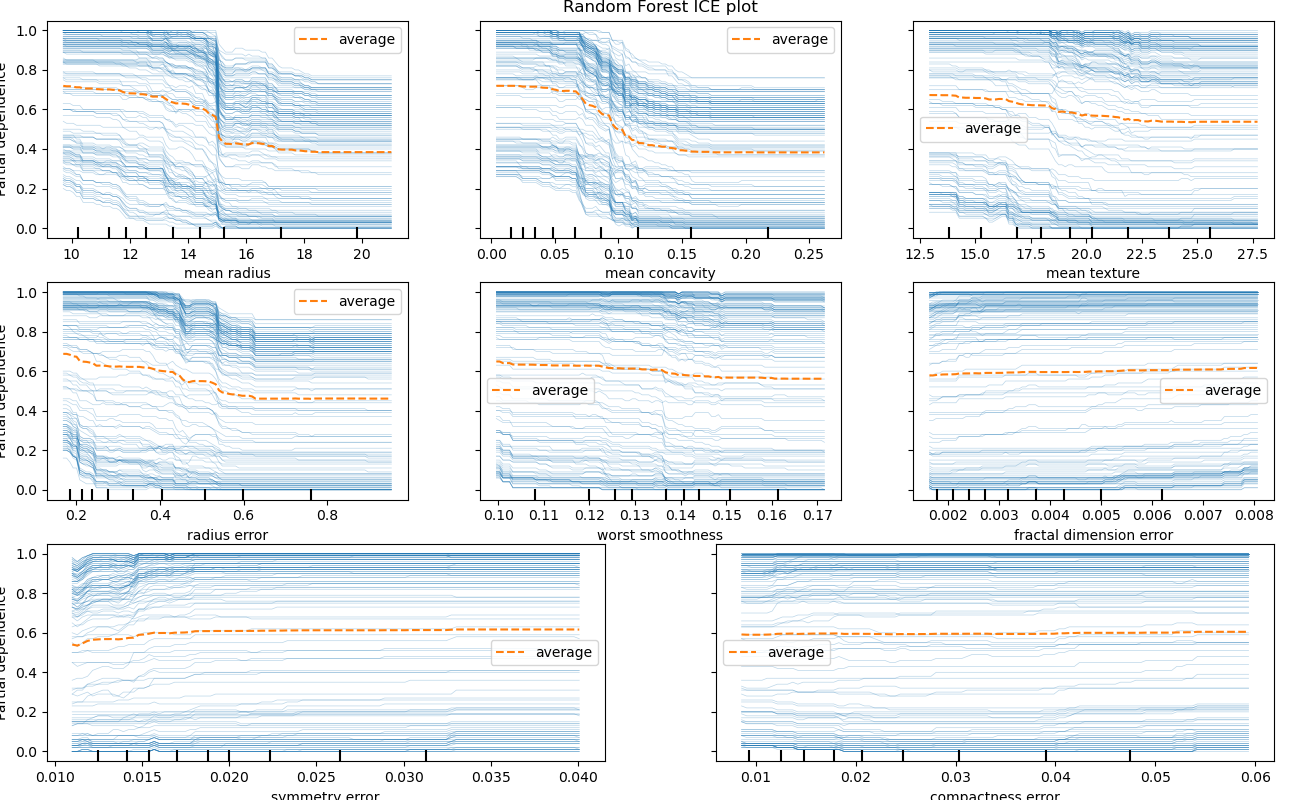

In [259]:
fig, ax = plt.subplots(3,1,figsize=(13, 8))
fig.tight_layout()
# ax[0]
ax[0].set_title("Random Forest ICE plot")
from sklearn.inspection import PartialDependenceDisplay

# PartialDependenceDisplay.from_estimator(clf, X_train, features=['mean radius', 'mean concavity','mean texture'],kind='both', ax=ax)
PartialDependenceDisplay.from_estimator(clf, X_test, features=['mean radius', 'mean concavity','mean texture'],kind='both', ax=ax[0])
PartialDependenceDisplay.from_estimator(clf, X_test, features=['radius error','worst smoothness', 'fractal dimension error'],kind='both', ax=ax[1])
PartialDependenceDisplay.from_estimator(clf, X_test, features=['symmetry error', 'compactness error'],kind='both', ax=ax[2])

# And the PDP

# Lets 3d plot these features

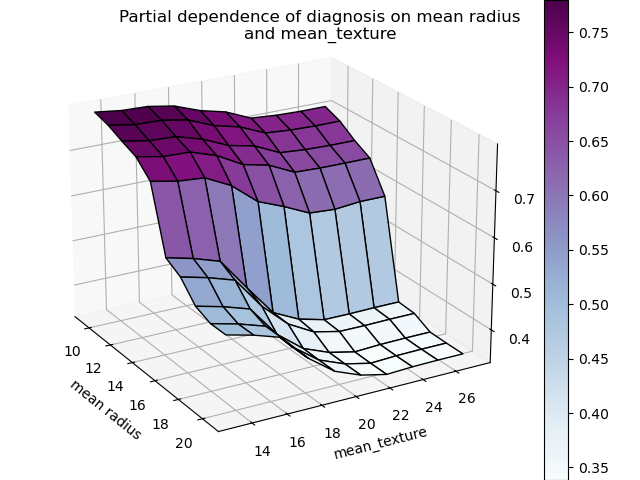

In [260]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

# features = ("AveOccup", "HouseAge")
pdp = partial_dependence(
    clf, X_train, features=[0,1], kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel('mean radius')
ax.set_ylabel('mean_texture')
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=-30)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of diagnosis on mean radius\n"
    "and mean_texture"
)
plt.subplots_adjust(top=0.9)
plt.show()